# Data Wrangling (Esto fue lo más difícil :'v)

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats 
import numpy as np


In [112]:
# Ruta de la carpeta que contiene los archivos CSV
data_path = r"C:\Users\Paul Tandazo\Desktop\DataMining Prueba Practica\data\raw"

# Cargar los datasets con la ruta completa
calls = pd.read_csv(os.path.join(data_path, "megaline_calls.csv"))
internet = pd.read_csv(os.path.join(data_path, "megaline_internet.csv"))
users = pd.read_csv(os.path.join(data_path, "megaline_users.csv"))
plans = pd.read_csv(os.path.join(data_path, "megaline_plans.csv"))
messages = pd.read_csv(os.path.join(data_path, "megaline_messages.csv"))
churn = pd.read_csv(os.path.join(data_path, "churn.csv"))

### La función miss muestra los valores faltantes en un DataFrame. 

In [113]:
def miss(df, name):
    print(f"\nValores faltantes en el dataset: {name}")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    print(f"Total de valores faltantes: {missing.sum()}")

In [114]:
miss(calls, "megaline_calls")
miss(internet, "megaline_internet")
miss(users, "megaline_users")
miss(plans, "megaline_plans")
miss(messages, "megaline_messages")
miss(churn, "churn")


Valores faltantes en el dataset: megaline_calls
Series([], dtype: int64)
Total de valores faltantes: 0

Valores faltantes en el dataset: megaline_internet
Series([], dtype: int64)
Total de valores faltantes: 0

Valores faltantes en el dataset: megaline_users
churn_date    466
dtype: int64
Total de valores faltantes: 466

Valores faltantes en el dataset: megaline_plans
Series([], dtype: int64)
Total de valores faltantes: 0

Valores faltantes en el dataset: megaline_messages
Series([], dtype: int64)
Total de valores faltantes: 0

Valores faltantes en el dataset: churn
Tenure    909
dtype: int64
Total de valores faltantes: 909


### Imputación de valores nulos

In [115]:
# Dataset churn - columna 'Tenure'
churn['Tenure'] = churn['Tenure'].fillna(churn['Tenure'].mean())

In [116]:
print("Valores faltantes después de la imputación:")
print(f"churn 'Tenure': {churn['Tenure'].isnull().sum()} faltantes")

Valores faltantes después de la imputación:
churn 'Tenure': 0 faltantes


In [117]:
# Dataset megaline_users - columna 'churn_date' se imputa con 'Activo' porque es categórica
users['churn_date'] = users['churn_date'].fillna('Activo')

In [118]:
print("Valores faltantes después de la imputación:")
print(f"megaline_users 'churn_date': {users['churn_date'].isnull().sum()} faltantes")

Valores faltantes después de la imputación:
megaline_users 'churn_date': 0 faltantes


### Detectar outliers y tratarlos

In [119]:
def detectar_outliers_internet(df):
    # Agrupar por user_id y sumar el uso total de datos (mb_used) por usuario
    uso_datos = df.groupby('user_id')['mb_used'].sum().reset_index(name='total_data_usage')
    
    # Calcular el IQR (rango intercuartílico)
    Q1 = uso_datos['total_data_usage'].quantile(0.25)
    Q3 = uso_datos['total_data_usage'].quantile(0.75)
    IQR = Q3 - Q1

    # Establecer los límites para detectar outliers
    lim_in = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    outliers_datos = uso_datos[(uso_datos['total_data_usage'] < lim_in) | (uso_datos['total_data_usage'] > lim_sup)]
    
    print(f"Outliers en el uso de datos (por IQR): {outliers_datos.shape[0]} registros")
    
    # Graficar un boxplot del uso total de datos por usuario
    plt.figure(figsize=(8,6))
    sns.boxplot(x=uso_datos['total_data_usage'])
    plt.title(f'Boxplot de uso total de datos por usuario')
    plt.show()

    return uso_datos, outliers_datos

Outliers en el uso de datos (por IQR): 8 registros


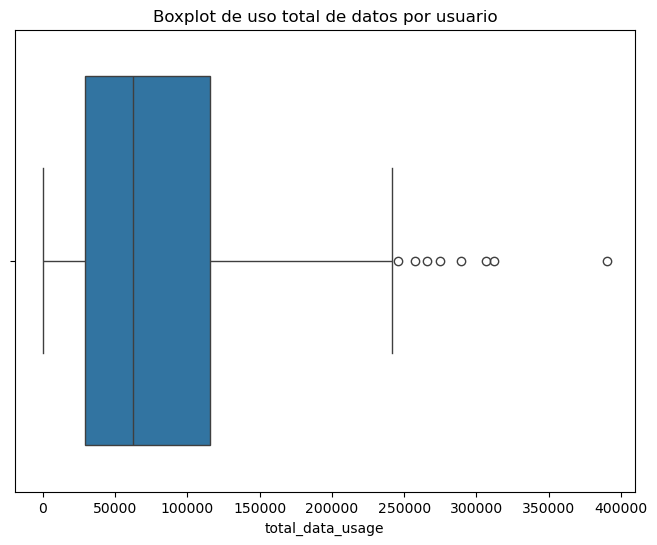

In [120]:
datos, outliers = detectar_outliers_internet(internet)

In [121]:
def detectar_outliers_sms(df):
    # Contar el número de mensajes por usuario
    mensaje_counts = df.groupby('user_id').size().reset_index(name='num_messages')
    
    # Aplicar el análisis IQR sobre la cantidad de mensajes por usuario
    Q1 = mensaje_counts['num_messages'].quantile(0.25)
    Q3 = mensaje_counts['num_messages'].quantile(0.75)
    IQR = Q3 - Q1

    # Limites
    lim_in = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    outliers_sms = mensaje_counts[(mensaje_counts['num_messages'] < lim_in) | (mensaje_counts['num_messages'] > lim_sup)]
    
    print(f"Outliers en mensajes (por IQR): {outliers_sms.shape[0]} registros")
    
    # Boxplot
    plt.figure(figsize=(8,6))
    sns.boxplot(x=mensaje_counts['num_messages'])
    plt.title(f'Boxplot de mensajes por usuario')
    plt.show()

    return mensaje_counts, outliers_sms

Outliers en mensajes (por IQR): 20 registros


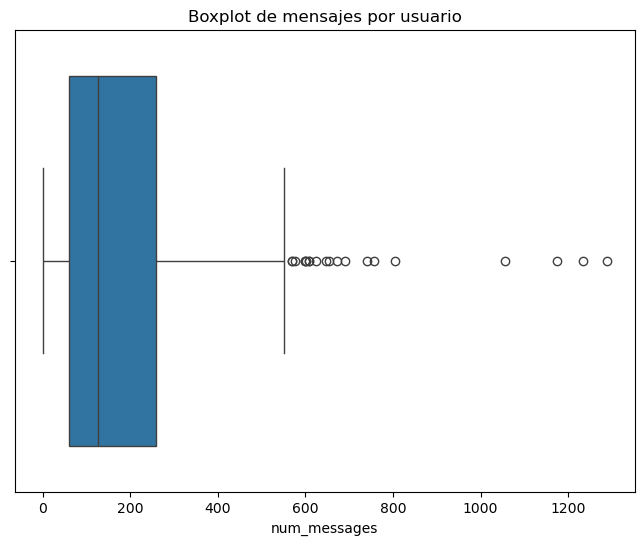

In [122]:
outliers_sms = detectar_outliers_sms(messages)

In [123]:
def detectar_outliers_llamadas(df):
    # Contar el número de llamadas por usuario
    llamada_counts = df.groupby('user_id')['duration'].sum().reset_index(name='total_duration')
    
    # Aplicar el análisis IQR sobre la duración total de las llamadas por usuario
    Q1 = llamada_counts['total_duration'].quantile(0.25)
    Q3 = llamada_counts['total_duration'].quantile(0.75)
    IQR = Q3 - Q1

    # Limites para detectar outliers
    lim_in = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    outliers_llamadas = llamada_counts[(llamada_counts['total_duration'] < lim_in) | (llamada_counts['total_duration'] > lim_sup)]
    
    print(f"Outliers en duración de llamadas (por IQR): {outliers_llamadas.shape[0]} registros")
    
    # Boxplot
    plt.figure(figsize=(8,6))
    sns.boxplot(x=llamada_counts['total_duration'])
    plt.title(f'Boxplot de duración total de llamadas por usuario')
    plt.show()

    return llamada_counts, outliers_llamadas


Outliers en duración de llamadas (por IQR): 16 registros


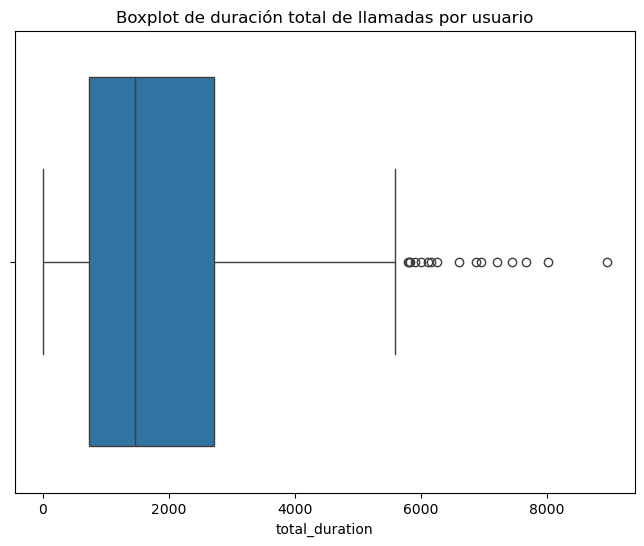

In [124]:
llamadas, outliers = detectar_outliers_llamadas(calls)

In [ ]:

def tratar_outliers_escalado(df, columna):
    # Calcular el Z-score para la columna especificada
    z_scores = stats.zscore(df[columna])
    
    # Definir un umbral para considerar outliers (por ejemplo, z-score > 3 o < -3)
    umbral_outlier = 3
    
    # Detectar los índices de los outliers
    outliers = np.where(np.abs(z_scores) > umbral_outlier)[0]
    
    # Imprimir la cantidad de outliers detectados
    print(f"Outliers detectados (por z-score > {umbral_outlier}): {len(outliers)} registros")
    
    # Sustituir los valores de outliers por el valor medio de la columna
    media_columna = df[columna].mean()
    df.loc[outliers, columna] = media_columna
    
    # Retornar el DataFrame con los outliers tratados
    return df


In [126]:
internet_tratado = tratar_outliers_escalado(internet, 'mb_used')

Outliers detectados (por z-score > 3): 371 registros


In [127]:
llamadas_tratado = tratar_outliers_escalado(calls, "duration")

Outliers detectados (por z-score > 3): 635 registros


In [182]:
users['is_churned'] = users['churn_date'].notnull().astype(int)

In [184]:
# Rango de fecha

from datetime import datetime
start_period = datetime(2018, 12, 1)
end_period   = datetime(2018, 12, 31, 23, 59, 59)

In [129]:
# Definir la ruta donde se guardarán los archivos
data_path = r"C:\Users\Paul Tandazo\Desktop\DataMining Prueba Practica\data\semiclean"

# Guardar los archivos con los cambios realizados
llamadas_tratado.to_csv(os.path.join(data_path, "megaline_calls.csv"), index=False)
internet_tratado.to_csv(os.path.join(data_path, "megaline_internet.csv"), index=False)
messages.to_csv(os.path.join(data_path, "megaline_messages.csv"), index=False)
users.to_csv(os.path.join(data_path, "megaline_users.csv"), index=False)
plans.to_csv(os.path.join(data_path, "megaline_plans.csv"), index=False)
churn.to_csv(os.path.join(data_path, "churn.csv"), index=False)


In [187]:
# Asegurarse de que las columnas de fecha están en el formato datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], errors='coerce')
internet['session_date'] = pd.to_datetime(internet['session_date'], errors='coerce')
messages['message_date'] = pd.to_datetime(messages['message_date'], errors='coerce')

# Filtrar registros en ese rango (en caso de que existan datos de otros periodos)
calls_period = calls[(calls['call_date'] >= start_period) & (calls['call_date'] <= end_period)]
internet_period = internet[(internet['session_date'] >= start_period) & (internet['session_date'] <= end_period)]
messages_period = messages[(messages['message_date'] >= start_period) & (messages['message_date'] <= end_period)]

# Agregar llamadas por usuario: cantidad de llamadas y suma de duración
calls_agg = calls_period.groupby('user_id').agg(
    total_calls=('id', 'count'),
    total_call_duration=('duration', 'sum')
).reset_index()

# Agregar internet por usuario: cantidad de sesiones y total MB usados
internet_agg = internet_period.groupby('user_id').agg(
    total_internet_sessions=('id', 'count'),
    total_mb_used=('mb_used', 'sum')
).reset_index()

# Agregar mensajes por usuario: cantidad total de mensajes enviados
messages_agg = messages_period.groupby('user_id').agg(
    total_messages=('id', 'count')
).reset_index()


In [188]:
# Definir la ruta donde se guardarán los archivos
data_path = r"C:\Users\Paul Tandazo\Desktop\DataMining Prueba Practica\data\semiclean"
# Cargar los datasets con la ruta completa
calls = pd.read_csv(os.path.join(data_path, "megaline_calls.csv"))
internet = pd.read_csv(os.path.join(data_path, "megaline_internet.csv"))
users = pd.read_csv(os.path.join(data_path, "megaline_users.csv"))
plans = pd.read_csv(os.path.join(data_path, "megaline_plans.csv"))
messages = pd.read_csv(os.path.join(data_path, "megaline_messages.csv"))
churn = pd.read_csv(os.path.join(data_path, "churn.csv"))

### Unificacion de las tablas para crear un dataset analtico que permita entrenar un modelo

In [195]:
analytic_df = users.copy()

# Unir llamadas
analytic_df = analytic_df.merge(calls_agg, on='user_id', how='left')
# Unir internet
analytic_df = analytic_df.merge(internet_agg, on='user_id', how='left')
# Unir mensajes
analytic_df = analytic_df.merge(messages_agg, on='user_id', how='left')

# Rellenar con 0 los NaN
analytic_df['total_calls'] = analytic_df['total_calls'].fillna(0)
analytic_df['total_call_duration'] = analytic_df['total_call_duration'].fillna(0)
analytic_df['total_internet_sessions'] = analytic_df['total_internet_sessions'].fillna(0)
analytic_df['total_mb_used'] = analytic_df['total_mb_used'].fillna(0)
analytic_df['total_messages'] = analytic_df['total_messages'].fillna(0)
analytic_df = analytic_df.merge(plans, left_on='plan', right_on='plan_name', how='left')

In [197]:
analytic_df.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,total_calls,total_call_duration,...,total_mb_used,total_messages,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,Activo,15.0,110.98,...,1901.47,11.0,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,Activo,4.0,13.46,...,1724.33,4.0,50,15360,500,20,10,0.03,0.03,surf
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,Activo,7.0,22.31,...,1646.11,5.0,50,15360,500,20,10,0.03,0.03,surf
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,Activo,15.0,84.56,...,6135.25,15.0,50,15360,500,20,10,0.03,0.03,surf
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,Activo,1.0,11.08,...,497.08,3.0,50,15360,500,20,10,0.03,0.03,surf


In [196]:
# Exportar el DataFrame analytic_df a un archivo CSV en la ruta especificada
output_path = r"C:\Users\Paul Tandazo\Desktop\DataMining Prueba Practica\data\semiclean\analytic_df.csv"
analytic_df.to_csv(output_path, index=False)

print(f"El archivo se ha exportado correctamente a {output_path}")



PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Paul Tandazo\\Desktop\\DataMining Prueba Practica\\data\\semiclean\\analytic_df.csv'